In [1]:
import jax.numpy as jnp
import jax
import jax.random as jr

from optimizers.gd import SGDState, sgd_step


from optimizers.mrcg import MRCGState, mrcg_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

## Model Definition

In [2]:
initial_params = jnp.array([1.0, 2.0, 3.0])

def model(params, x):
    return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

def loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y_true = jnp.array([[1.0], [2.0]])

def loss_at_params(params, key=None):
    y_pred = model(params, x)
    return loss(y_pred, y_true)


In [3]:
def harder_model(params, x):
    return (
        jnp.sin(x[:, 0] * params[0]) +
        jnp.exp(-x[:, 1] * params[1]) +
        (x[:, 2] ** 2) * params[2] * jnp.sin(params[2])
    )

x = jnp.array([
        [1.0, 2.0, 3.0],
        [1.0, 5.0, -2.0],
        [0.0, 14.0, 3.0],
        [3.0, 2.0, 8.0]
        ])

## Optimizers Comparison

In [4]:
def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    key = jr.PRNGKey(0)
    for i in range(max_iters):
        key, subkey = jr.split(key)
        loss = state.loss_at_params(state.params, subkey)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

Iteration 0: Loss = 14379.93359375 Params = [-32.3325  -55.84501]
Iteration 1: Loss = 441700.6875 Params = [171.9902  360.32874]
Iteration 2: Loss = 17369844.0 Params = [-1067.2823 -2295.6284]
Iteration 3: Loss = 701052288.0 Params = [ 6772.0303 14613.857 ]
Iteration 4: Loss = 28384952320.0 Params = [-43083.47 -93010.84]
Iteration 5: Loss = 1149717839872.0 Params = [274191.72 591968.9 ]
Iteration 6: Loss = 46570997284864.0 Params = [-1745079.2 -3767580. ]
Iteration 7: Loss = 1886436743708672.0 Params = [11106531. 23978724.]
Iteration 8: Loss = 7.64133780708393e+16 Params = [-7.0687400e+07 -1.5261235e+08]
Iteration 9: Loss = 3.0952560740731453e+18 Params = [4.4988928e+08 9.7129971e+08]
Iteration 10: Loss = 1.2537868310580874e+20 Params = [-2.8633155e+09 -6.1818260e+09]
Iteration 11: Loss = 5.078678900488224e+21 Params = [1.8223538e+10 3.9344165e+10]
Iteration 12: Loss = 2.0572062994019876e+23 Params = [-1.1598351e+11 -2.5040550e+11]
Iteration 13: Loss = 8.3330687571748e+24 Params = [7.3

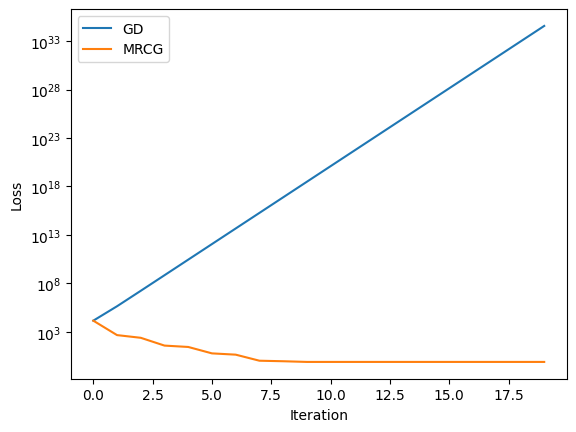

In [5]:
def plot_alg_comparison(ro, initial_params, max_iters=20):
    key = jr.PRNGKey(0)
    sgd_losses = iterate_alg(
        max_iters,
        SGDState(
            initial_params,
            loss_at_params,
            0.05,
            key,
        ),
        sgd_step,
        verbose=True
    )


    mrcg_losses = iterate_alg(
        max_iters,
        MRCGState(initial_params, loss_at_params, key),
        mrcg_step,
        verbose=True
    )
    plt.plot(sgd_losses, label='GD')
    plt.plot(mrcg_losses, label='MRCG')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plot_alg_comparison(rosenbrock_loss, jnp.array([12, 8.1]), max_iters=20)

Iteration 0: Loss = 14379.93359375 Params = [-32.3325  -55.84501]
Iteration 1: Loss = 441700.6875 Params = [171.9902  360.32874]
Iteration 2: Loss = 17369844.0 Params = [-1067.2823 -2295.6284]
Iteration 3: Loss = 701052288.0 Params = [ 6772.0303 14613.857 ]
Iteration 4: Loss = 28384952320.0 Params = [-43083.47 -93010.84]
Iteration 5: Loss = 1149717839872.0 Params = [274191.72 591968.9 ]
Iteration 6: Loss = 46570997284864.0 Params = [-1745079.2 -3767580. ]
Iteration 7: Loss = 1886436743708672.0 Params = [11106531. 23978724.]
Iteration 8: Loss = 7.64133780708393e+16 Params = [-7.0687400e+07 -1.5261235e+08]
Iteration 9: Loss = 3.0952560740731453e+18 Params = [4.4988928e+08 9.7129971e+08]
Iteration 10: Loss = 1.2537868310580874e+20 Params = [-2.8633155e+09 -6.1818260e+09]
Iteration 11: Loss = 5.078678900488224e+21 Params = [1.8223538e+10 3.9344165e+10]
Iteration 12: Loss = 2.0572062994019876e+23 Params = [-1.1598351e+11 -2.5040550e+11]
Iteration 13: Loss = 8.3330687571748e+24 Params = [7.3

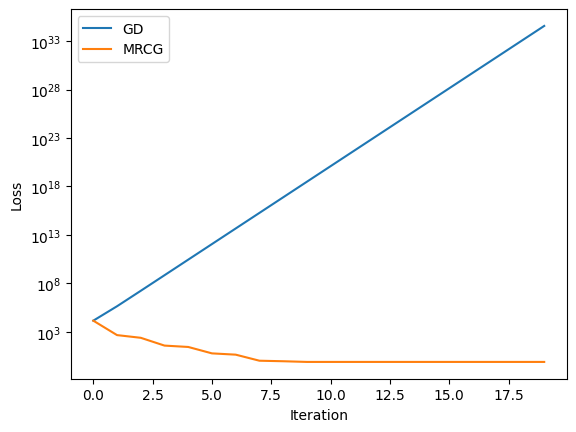

In [6]:
plot_alg_comparison(beale_loss, jnp.array([12, 8.1]), max_iters=20)

## Stochastic

In [7]:
def make_stochastic_mse_loss(x_data: jnp.ndarray, y_data: jnp.ndarray, batch_size: int):
    """
    Returns a loss function that computes MSE on a random mini-batch.
    
    Args:
        x_data: shape (N, D)
        y_data: shape (N,)
        batch_size: int

    Returns:
        loss_fn(params, key): stochastic loss function
    """
    N = x_data.shape[0]

    def loss_fn(params: jnp.ndarray, key: jax.random.PRNGKey) -> jnp.ndarray:
        idx = jax.random.choice(key, N, shape=(batch_size,), replace=False)
        x_batch = x_data[idx]
        y_batch = y_data[idx]

        preds = x_batch @ params
        return jnp.mean((preds - y_batch) ** 2)

    return loss_fn


Iteration 0: Loss = 2.5 Params = [0.4125     0.8625     0.45000002 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 1: Loss = 52.34383010864258 Params = [-1.39125   -4.078125  -1.9846876  0.         0.         0.
  0.         0.         0.         0.       ]
Iteration 2: Loss = 1569.4073486328125 Params = [ 8.078977 23.6805   10.776891  0.        0.        0.        0.
  0.        0.        0.      ]
Iteration 3: Loss = 47845.41796875 Params = [ -42.74054 -130.62604  -58.65624    0.         0.         0.
    0.         0.         0.         0.     ]
Iteration 4: Loss = 1460047.625 Params = [235.04752 723.9693  322.2513    0.        0.        0.        0.
   0.        0.        0.     ]
Iteration 5: Loss = 44559136.0 Params = [-1292.853  -4001.8364 -1776.4594     0.         0.         0.
     0.         0.         0.         0.    ]
Iteration 6: Loss = 1359917568.0 Params = [ 7133.4165 22115.795   9805.314      0.         0.         0.
     0.         0. 

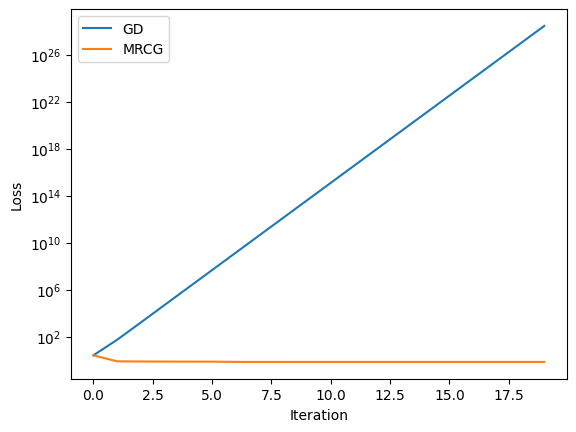

In [8]:
# Generate synthetic data
import jax.random as jr


key = jr.PRNGKey(0)
N, D = 1000, 10
x_data = jr.normal(key, (N, D))
true_w = jnp.arange(1, D + 1)
y_data = x_data @ true_w + 0.1 * jr.normal(key, (N,))

# Create loss function
batch_size = 32
loss_fn = make_stochastic_mse_loss(x_data, y_data, batch_size)

# Initialize parameters and SGD state
init_params = jnp.zeros(D)
plot_alg_comparison(
    loss_fn,
    init_params,
    max_iters=20
)

## Mnist

In [9]:
from models.mnist import loss_at_params, train_accuracy, test_accuracy, flat_params, predict
%reload_ext autoreload
%autoreload 2

init_params = flat_params
init_params.shape

(1863690,)

In [10]:

print(f"Train accuracy: {train_accuracy(init_params):.2f}")
print(f"Validation accuracy: {test_accuracy(init_params):.2f}")

Train accuracy: 0.11
Validation accuracy: 0.11


In [11]:


sgd_losses = iterate_alg(
    1,
    SGDState(
        init_params,
        loss_at_params,
        0.005,
        key,
    ),
    sgd_step,
    verbose=True
)

Iteration 0: Loss = 2.327737808227539 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01486882 -0.00153295
 -0.00921033]


In [12]:

print(f"Train accuracy: {train_accuracy(init_params):.2f}")
print(f"Validation accuracy: {test_accuracy(init_params):.2f}")

Train accuracy: 0.11
Validation accuracy: 0.11


Iteration 0: Loss = 2.327737808227539 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01319594  0.00023828
 -0.01052236]
Iteration 1: Loss = 2.2790780067443848 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01630091  0.00012303
 -0.01372495]
Iteration 2: Loss = 2.2570950984954834 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.0126222   0.0002916
 -0.01389931]
Iteration 3: Loss = 2.1889352798461914 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01255061 -0.00045
 -0.01444883]
Iteration 4: Loss = 2.107649326324463 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01409196 -0.00081871
 -0.01299312]
Iteration 5: Loss = 2.094935417175293 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01248041  0.00031567
 -0.0139685 ]
Iteration 6: Loss = 2.083148956298828 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.0108264  -0.00276558
 -0.01248262]
Iteration 7: Loss = 1.9831926822662354 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01205748 -0.0047791
 -0.014

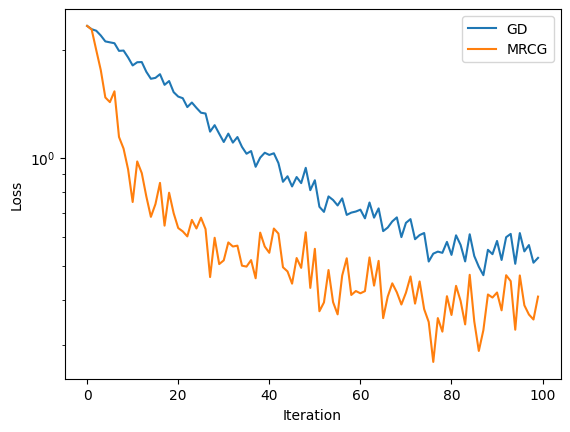

In [13]:
plot_alg_comparison(
    loss_fn,
    init_params,
    max_iters=100
)